Wayne Nixalo - 18:02 - 7 Jan 2018

---

# Image Overlay Development

## 0. Imports

In [74]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import cv2
import os
import matplotlib.pyplot as plt
import numpy as np # for stacking grayscale

# PATH = ''
# os.getcwd()
# if os.getcwd() != PATH
#     os.chdir(os.getcwd() + PATH)
# os.getcwd()

In [84]:
plt.rcParams["figure.figsize"] = (8,8)
plt.style.use('default')

## 1. Overlaying Images

In [2]:
image = cv2.imread('blah.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Openning a test image:

In [4]:
image = cv2.imread('blah.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

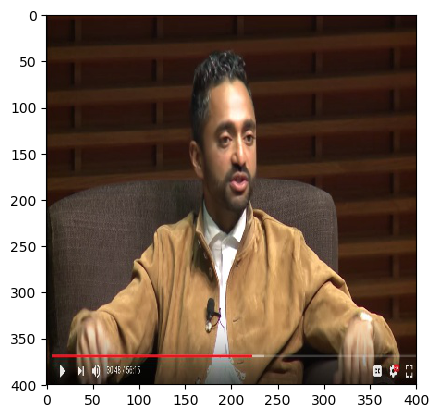

In [21]:
plt.imshow(image)

Making a blackened-image by zeroing a copy:

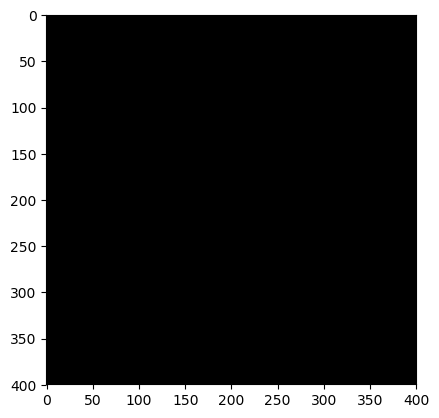

In [22]:
aerzh_img = image.copy()
aerzh_img[:] = 0
plt.imshow(aerzh_img)

Making sure dimension order is HEIGHT,WIDTH (ROW,COLUMN):

(400, 400, 3)
(100, 400, 3)


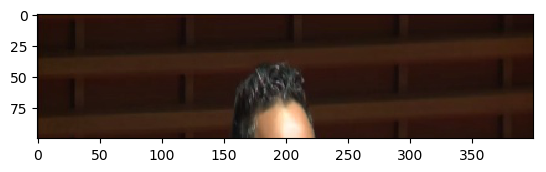

In [26]:
print(image.shape)
print(image[:100,:,:].shape)
plt.imshow(image[:100,:,:]);

The overlay function. Adapted from Lex Fridman's Boring Detector, adapted from a StackExchange thread.

First it makes sure the offsets place the foreground image within the bounds of the background image. Then it makes a copy of the bg image.

Then it checks if the fg image has an alpha (transparancy, found in `.png` files) or not. If it does, the function takes care of some math overlay the fg image atop the bg image. Don't yet exactly know how it does this. Something about multiplying each color channel by the normalized alpha-channel value, then multiplying each 'cell' of the image by 1 - the normalized alpha-channel value.

Overlaying a `.jpg` image is very easy - it just copys it on top.

In [101]:
# overlay: http://stackoverflow.com/a/14102014/627517
# via: https://sourcegraph.com/github.com/lexfridman/boring-detector@master/-/blob/boring_common.py#L60
def overlay_image(λ_img, s_img, x_offset=0, y_offset=0):
    assert y_offset + s_img.shape[0] <= λ_img.shape[0]
    assert x_offset + s_img.shape[1] <= λ_img.shape[1]

    λ_img = λ_img.copy()

    # if an alpha-channel exists in fg-image: remove it
    if s_img.shape[-1] == 4:
        for c in range(0, 3):
            λ_img[y_offset:y_offset+s_img.shape[0],
                  x_offset:x_offset+s_img.shape[1], c] = (
                                s_img[:,:,c] * (s_img[:,:,3]/255.) +
                                λ_img[y_offset:y_offset+s_img.shape[0],
                                      x_offset:x_offset+s_img.shape[1], c] *
                                (1. - s_img[:,:,3]/255.))
    else:
        # no alpha-channel:
        λ_img[y_offset:y_offset+s_img.shape[0],
              x_offset:x_offset+s_img.shape[1]] = s_img

    return λ_img

Overlaying a slice of the image over a black background:

In [34]:
in_img = image[50:200,150:250,:]
xof = (image.shape[1] - in_img.shape[1])//2
yof = (image.shape[0] - in_img.shape[0])//2
overlayed = overlay_image(aerzh_img, in_img, x_offset=xof, y_offset=yof)

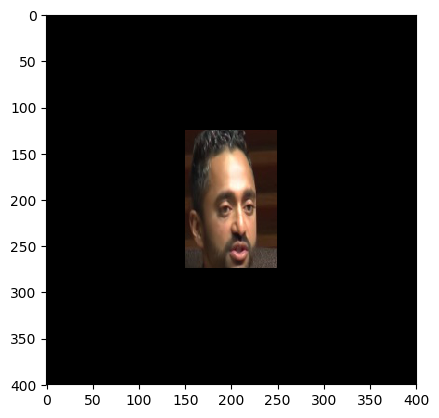

In [35]:
plt.imshow(overlayed)

## 2. Cropping Images --> Overlay

The G-LOC Detector pipeling will be taking images cropped from bounding boxes and saving them to a temporary folder which'll be used as the input for the detection stage. I *think* the Fast.ai library fills in extra space from crops with black, so that's what I'll be doing. I already have a `crop` function, so I'll paste that below:

In [36]:
# pulled from utils.common.py
def crop(image, bbox):
    """
    bbox:[x1,y1,x2,y2]
    roi: [y1:y2,x1:x2]
    image: (ndarray)
    """
    p1,p2 = (bbox[0],bbox[1]), (bbox[2],bbox[3])
    crop = image.copy()
    return crop[p1[1]:p2[1], p1[0]:p2[0]]

In [39]:
ricedude = cv2.imread('ricedude.jpg')
# no color conversion needed since image is already grayscale -- I *think*.

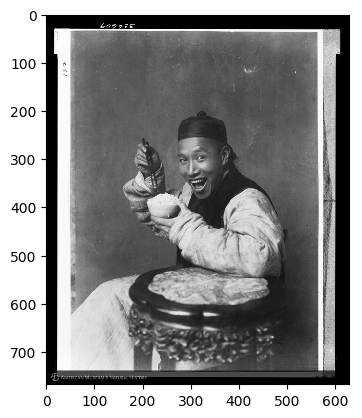

In [41]:
plt.imshow(ricedude);

**NOTE**: RetinaNet generated bounding boxes are in `[x1,y1, x2, y2]` format. OpenCV regions of interest are formatted: `[y1:y2, x1:x2]`. `common.crop` has been written to take in the bounding-box format and handle conversion.

In [42]:
bbox = [250,200,350,400]

In [43]:
cropped = crop(ricedude, bbox)

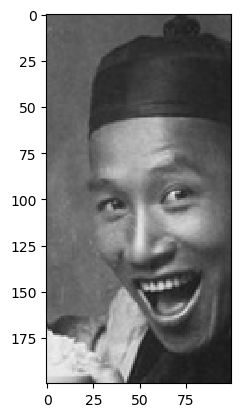

In [46]:
plt.imshow(cropped)

I can't stop laughing.

In [48]:
bbox = [270,200,370,390]
cropped = crop(ricedude, bbox)

In [50]:
cropped.shape

(190, 100, 3)

In [52]:
image.shape

(400, 400, 3)

In [53]:
yof + cropped.shape[0] <= image.shape[0]

True

In [ ]:
overlay_image

In [56]:
xof = (image.shape[1] - cropped.shape[1])//2
yof = (image.shape[0] - cropped.shape[0])//2
overlayed = overlay_image(aerzh_img, cropped, xof, yof)

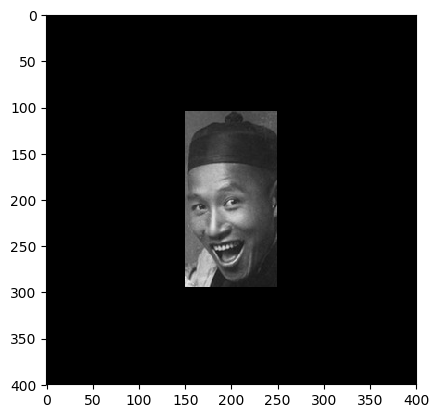

In [57]:
plt.imshow(overlayed)

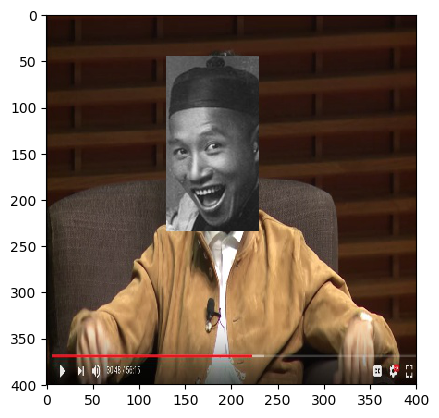

In [65]:
xof = (image.shape[1] - cropped.shape[1])//2 - 20
yof = (image.shape[0] - cropped.shape[0])//2 - 60
overlayed = overlay_image(image, cropped, xof, yof)
plt.imshow(overlayed)

Looks like it works.

---

Grayscaling an image, but keeping its color channel dimension:

In [89]:
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # removes channel dim
image_gray = np.expand_dims(image_gray, 2) # add empty dim
image_gray = np.concatenate((image_gray, image_gray, image_gray), axis=2)
# populate 3rd dim w/ (3) copies of image.

In [90]:
image_gray.shape

(400, 400, 3)

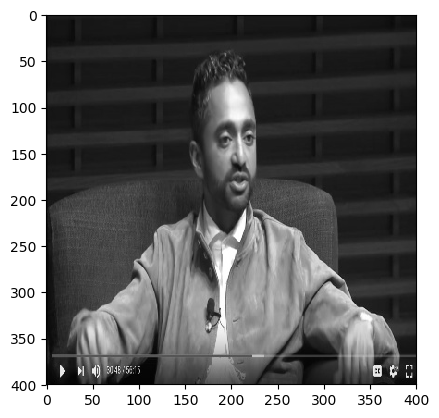

In [85]:
plt.imshow(image_gray)

---

Playing with what should not be played with.

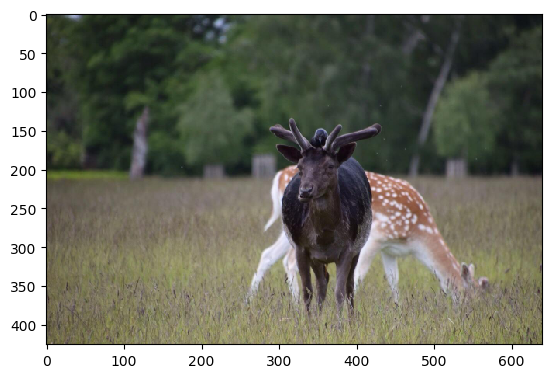

In [91]:
img = cv2.imread('toolate.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
plt.imshow(img)

I can make an image semi-transparant by substituting the index of one of the color channels for the alpha-channel index.

In [100]:
def overlay_image_temp(λ_img, s_img, x_offset=0, y_offset=0, channel=0):
    assert y_offset + s_img.shape[0] <= λ_img.shape[0]
    assert x_offset + s_img.shape[1] <= λ_img.shape[1]

    λ_img = λ_img.copy()
        
    for c in range(0, 3):
        λ_img[y_offset:y_offset+s_img.shape[0],
              x_offset:x_offset+s_img.shape[1], c] = (
                            s_img[:,:,c] * (s_img[:,:,channel]/255.) +
                            λ_img[y_offset:y_offset+s_img.shape[0],
                                  x_offset:x_offset+s_img.shape[1], c] *
                            (1. - s_img[:,:,channel]/255.))

    return λ_img

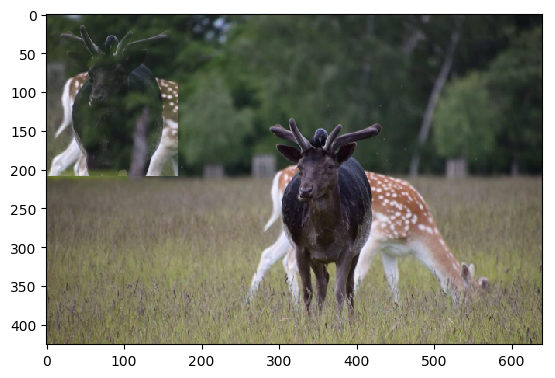

In [115]:
big_aerzh = img.copy()
big_aerzh[:] = 0
overlay = overlay_image_temp(img, img[120:330,270:440], channel=2)
plt.imshow(overlay)

Omg. It's Bambi Lion King.

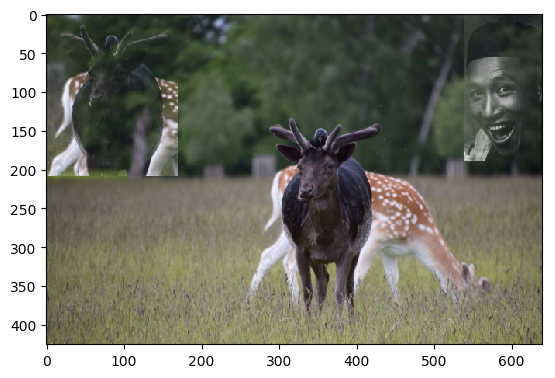

In [117]:
xof = overlay.shape[1] - cropped.shape[1]
better_overlay = overlay_image_temp(overlay, cropped, x_offset=xof)
plt.imshow(better_overlay)

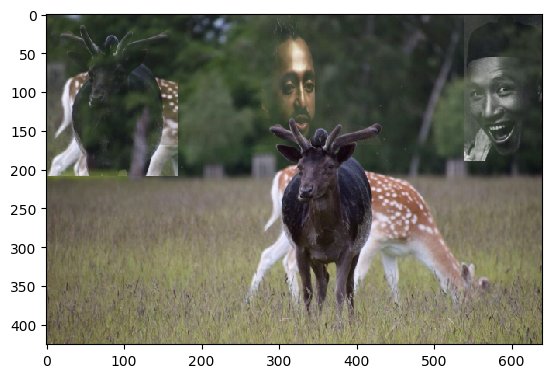

In [132]:
image_crop = crop(image, [0,40,400,210])

xof = (better_overlay.shape[1]-image_crop.shape[1])//2
best_overlay = overlay_image_temp(better_overlay, image_crop, x_offset=xof, channel=2)
plt.imshow(best_overlay)

So uh, yeah. Looks like overlaying the cropped images works.

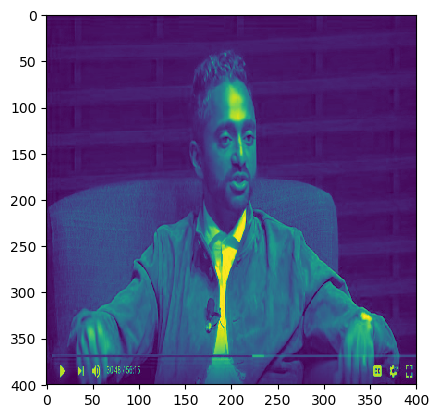

In [139]:
plt.imshow(image[:,:,2])

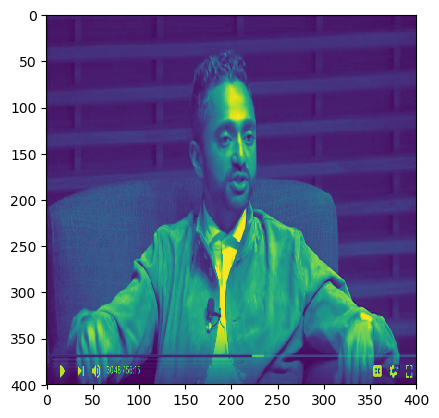

In [140]:
plt.imshow(image[:,:,1])

Got it, `matplotlib.pyplot` uses the raw pixel values to place a color (on it's default spectrum) if no color-channel dimension is availble.